In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fBiPotDDims.recursive_Markovian_PostMeanScore_fBiPot8Dims_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [7]:
import pandas as pd
def get_drift_files_nonfull(config, root_dir ):
    ts_type = f"{config.ndims}DDims"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/8DDims/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "bwidx" in file and "MSEs" not in file:
                mses_full = pd.read_parquet(root_nadaraya_dir+file)
                mses.append(mses_full)
    mses = pd.concat(mses).sort_values("bw", axis=0).dropna()
    print(mses)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

           bw          mse
0    0.000282  2094.346191
1    0.000372  2094.394775
2    0.000491  2094.332520
3    0.000649  2094.330322
4    0.000857  2094.240967
5    0.001131  2094.129883
6    0.001493  2093.924072
7    0.001972  2093.613037
8    0.002603  2092.964111
9    0.003437  2091.703369
10   0.004538  2089.385742
11   0.005992  2085.475586
12   0.007912  2078.938477
13   0.010446  2067.515869
14   0.013793  2047.024536
15   0.018211  2010.684204
16   0.024046  1953.349854
17   0.031749  1863.097534
18   0.041919  1719.798950
19   0.055348  1496.014282
20   0.073079  1170.180054
21   0.096490   760.059143
22   0.127401   367.104401
23   0.168214   123.573784
24   0.222102    31.249811
25   0.293252     8.519623
26   0.387196     5.770772
27   0.511235     6.970950
28   0.675010     8.735860
29   0.891251    10.318186
30   1.135011    11.267986
31   1.445440    11.863356
32   1.840772    12.277597
33   2.344229    12.583964
34   2.985383    12.802202
35   3.801894    12.949352
3

Text(0.5, 1.0, 'Minimum MSE is (5.7707715, 26)')

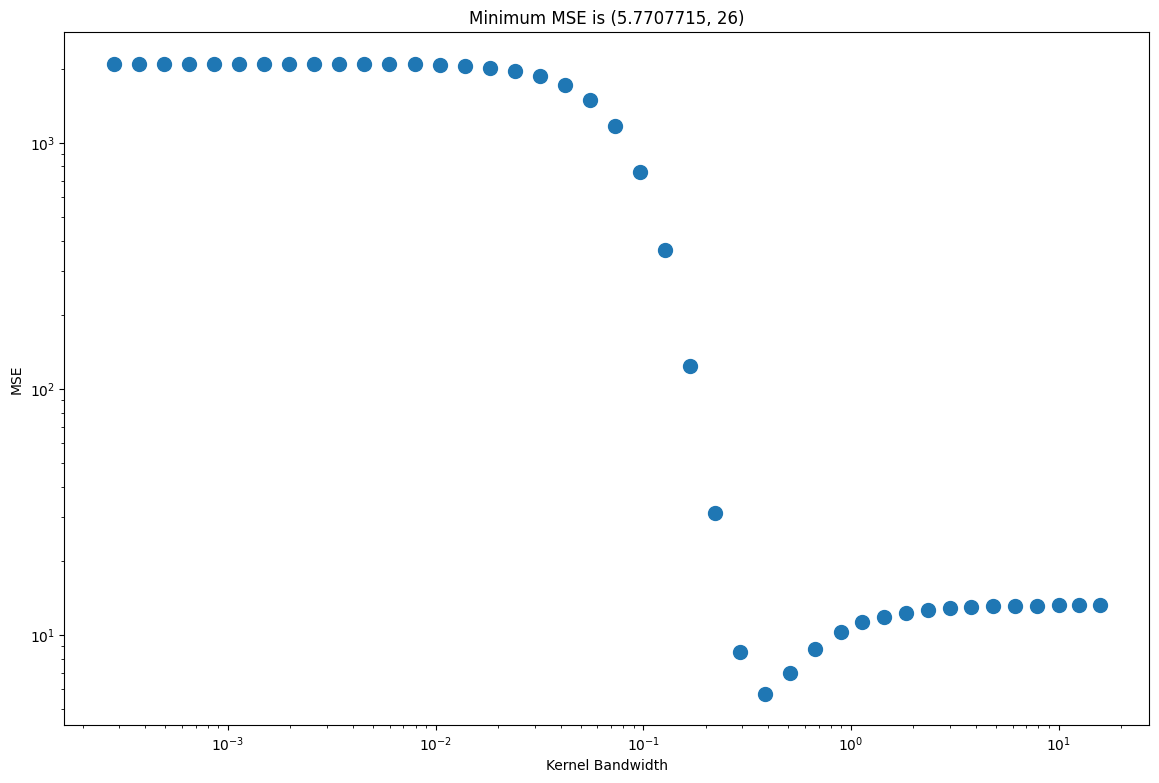

In [9]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files_nonfull(config=config, root_dir=root_dir)
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 1], np.argmin(mses.mse)}")